Prof Matheus : 11932297847

### Aula 7 - Processamento digital de Áudio (PDA) - Aplicações

- Classificação de sons : Criação de um ranking de similaridade das músicas presentes na plataforma. Essa operação requer um sistema de aprendiazaod de máquina ou de aprendizado profundo, permitindo um ranking em larga escala.

- Classificação de estilos musicais ou origem de um som.

- Iremos utilizar o Urban Sound 8k dataset (https://www.kaggle.com/datasets/chrisfilo/urbansound8k) - 7GB

- Utiliza-se a biblioteca librosa para o processamento de áudio e a biblioteca sklearn para modelagem

In [19]:
# Carregando os módulos
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import random
from fnmatch import fnmatch
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [20]:
# Todas as músicas tem 30 segundos
audio_1 = "sounds/classical.00012.wav"
audio_2 = "sounds/classical.00024.wav"
audio_3 = "sounds/hiphop.00012.wav"
audio_4 = "sounds/hiphop.00024.wav"

In [25]:
Audio(audio_4, rate = 44_100)

In [36]:
# Função para ouvir o áudio - alterar root 
def selecione_audio_aleatorio(root = 'sounds'):
    pattern = "*.wav"
    sounds = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            if fnmatch(name, pattern):
                sounds.append(os.path.join(path, name))
        # Retorne o caminho de um áudio .wav aleatório
    return random.choice(sounds)

# Executando o áudio
Audio(selecione_audio_aleatorio())

##### O retorno da função acima é o caminho do arquivo. Podemos investigar o formato do som utilizando a biblioteca librosa.

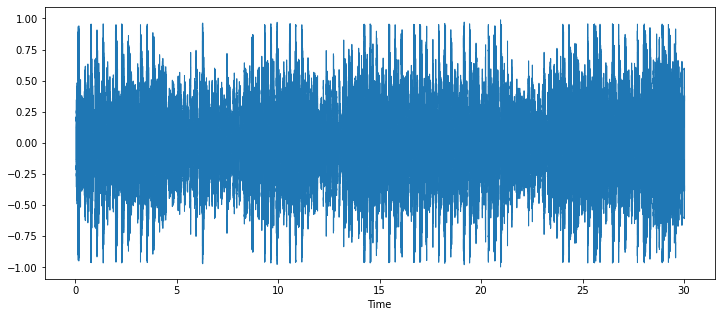

In [37]:
data, sr = librosa.load(selecione_audio_aleatorio())
plt.figure(figsize=(12, 5))
librosa.display.waveshow(data, sr=sr)

### MFCC (Mel-frequency cepstrum coefficients)

- O MFCC permite identificar as distribuições de frequências ao longo de uma janela definida. Portanto é possível analisar tanto a frequência como o tempo de cada som (similar ao espectrograma). Portanto, iremos utilizar esse recurso para conseguir converter a onda sonora em um vetor numérico permitindo que este seja utilizado na classificação de cada áudio.
- https://link.springer.com/content/pdf/bbm%3A978-3-319-49220-9%2F1.pdf

- A técnica de extração de features MFCC inclui isolar o sinal, aplicar DFT, tomar o log da magnitude, aplicar escal de Mel nas frequências e aplicar o inverso do DCT (Discrete Cosine Transform).  

In [15]:
data, sr = librosa.load(selecione_audio_aleatorio())
mfcc_40 = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print(mfcc_40.shape)  # (Número de coeficiente (`n_mfcc`), tempo)
# -> 40, ... # Note que o tempo varia de som para som
mfcc_80 = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=80)
print(mfcc_80.shape)  # (Número de coeficiente (`n_mfcc`), tempo)
# -> 80, ... # Note que o tempo varia de som para som
print(mfcc_80)

(40, 28)
(80, 28)
[[-357.2044     -246.52028    -213.17831    ... -216.12599
  -220.30478    -221.91815   ]
 [ 126.810684    123.54152     114.97702    ...   97.626495
    91.814705     99.47656   ]
 [ -35.418877    -33.59114     -37.8841     ...  -43.222645
   -38.30635     -33.064766  ]
 ...
 [   0.4540639    -0.53876495   -1.6585755  ...   -1.0694273
     1.5393194     1.0711974 ]
 [  -2.7838278    -4.939737     -4.1516995  ...   -4.2624016
    -3.4248323    -4.524054  ]
 [  -5.162348     -1.7813287     4.5897045  ...   -2.7391472
     0.9829942    -4.1065865 ]]


Note que o número de features presente será o número de coeficientes que foi inserido com o parâmetro n_mfcc , neste exemplo utilizamos dois retornos, 40 e 80. Essa transformação é similar quando utilizamos o Word2Vec ou Doc2Vec em processamento de linguagem natural, em que inserimos o tamanho do vetor resultante.

Aqui observamos um problema, em que os modelos que estamos acostumados a trabalhar aceitam um vetor e não uma matriz, para resolver esse problema podemos transpor essa matriz, de (n_mfcc x tempo), para (tempo x n_mfcc), e depois aplicar uma operação matemática como a média. Ou seja, para cada coeficiente teremos uma média da intensidade de frequência ao longo do tempo.

In [16]:
data, sr = librosa.load(selecione_audio_aleatorio())
mfcc_40 = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print(mfcc_40.shape)  # (Número de coeficiente (`n_mfcc`), tempo)
# -> (40, ...) # Note que o tempo varia de som para som
mfcc_40_media = np.mean(mfcc_40.T, axis=0)
print(mfcc_40_media.shape)
# -> (40,)

(40, 28)
(40,)


In [17]:
def audio2feature(file_path, n_mfcc=40):
    # Carregando o áudio
    audio, sr = librosa.load(file_path, res_type='kaiser_fast') 
    # Extraindo as features
    mfcc_feature = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    # Removendo a multidimensionalidade aplicando a média da matriz transposta
    mfcc_feature_escalonada = np.mean(mfcc_feature.T,axis=0)
    return mfcc_feature_escalonada

In [ ]:
extracted_features=[]
audio_dataset_path = './data'
for index_num,row in (sound_df.iterrows()):
    file_path_list = [os.path.abspath(audio_dataset_path), # Path folder dados
                      'fold'+str(row["fold"])+'/',  # Qual o `fold[1-10]`
                      str(row["slice_file_name"])]  # Nome do arquivo .wav
    file_path = os.path.join(*file_path_list) # Fazendo o unpacking e juntando tudo em um único caminho
    final_class_labels=row["class"] # A qual classe o arquivo pertence
    feature = audio2feature(file_path) # Extraindo as features do arquivo (note n_mfcc=40)
    extracted_features.append([feature,final_class_labels])

# Transformando em um dataframe
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

In [ ]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [ ]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [ ]:
# Instanciando o modelo
model = RandomForestClassifier()
# Fit dos dados de treino
model.fit(X_train, y_train)
# Predict com dados de teste
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

f, ax= plt.subplots(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labelencoder.classes_);
ax.yaxis.set_ticklabels(labelencoder.classes_);
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
plt.xticks(rotation="vertical")
plt.yticks(rotation="horizontal")